**9장 – 비지도 학습**

_이 노트북은 9장에 있는 모든 샘플 코드와 연습문제 해답을 가지고 있습니다._

<table align="left">
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/rickiepark/handson-ml2/blob/master/09_unsupervised_learning.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png" />구글 코랩에서 실행하기</a>
  </td>
</table>

# 설정

먼저 몇 개의 모듈을 임포트합니다. 맷플롯립 그래프를 인라인으로 출력하도록 만들고 그림을 저장하는 함수를 준비합니다. 또한 파이썬 버전이 3.5 이상인지 확인합니다(파이썬 2.x에서도 동작하지만 곧 지원이 중단되므로 파이썬 3을 사용하는 것이 좋습니다). 사이킷런 버전이 0.20 이상인지도 확인합니다.

In [1]:
# 파이썬 ≥3.5 필수
import sys
assert sys.version_info >= (3, 5)

# 사이킷런 ≥0.20 필수
import sklearn
assert sklearn.__version__ >= "0.20"

# 공통 모듈 임포트
import numpy as np
import os

# 노트북 실행 결과를 동일하게 유지하기 위해
np.random.seed(42)

# 깔끔한 그래프 출력을 위해
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# 그림을 저장할 위치
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "unsupervised_learning"
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID)
os.makedirs(IMAGES_PATH, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("그림 저장:", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

# 군집

**소개 – 분류 _vs_ 군집**

In [2]:
from sklearn.datasets import load_iris # 4장의 붓꽃데이터 / 차원축소 또한 비지도 학습방법이다!

In [3]:
data = load_iris()
X = data.data
y = data.target
data.target_names

array(['setosa', 'versicolor', 'virginica'], dtype='<U10')

그림 저장: classification_vs_clustering_plot


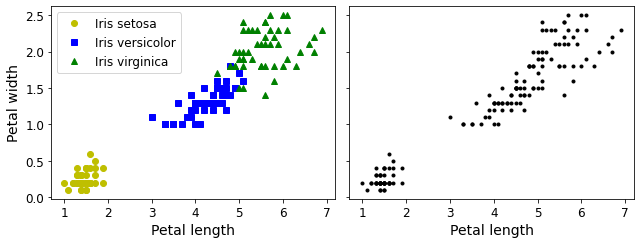

In [4]:
plt.figure(figsize=(9, 3.5))

plt.subplot(121)
plt.plot(X[y==0, 2], X[y==0, 3], "yo", label="Iris setosa")
plt.plot(X[y==1, 2], X[y==1, 3], "bs", label="Iris versicolor")
plt.plot(X[y==2, 2], X[y==2, 3], "g^", label="Iris virginica")
plt.xlabel("Petal length", fontsize=14)
plt.ylabel("Petal width", fontsize=14)
plt.legend(fontsize=12)

plt.subplot(122)
plt.scatter(X[:, 2], X[:, 3], c="k", marker=".")
plt.xlabel("Petal length", fontsize=14)
plt.tick_params(labelleft=False)

save_fig("classification_vs_clustering_plot")
plt.show()

(아래에서 설명할) 가우시안 혼합 모델은 3개의 클러스터를 잘 나눌 수 있습니다(꽃잎 길이와 너비, 꽃받침 길이와 너비 4개의 특성을 모두 사용합니다).

In [5]:
from sklearn.mixture import GaussianMixture #가우시안 혼합모델 예시

In [6]:
y_pred = GaussianMixture(n_components=3, random_state=42).fit(X).predict(X)

각 클러스터를 하나의 클래스에 매핑해보죠. 이 매핑을 (책에서처럼) 하드 코딩하는 대신 (`scipy.stats.mode()` 함수를 사용해) 각 클러스터에서 가장 많은 클래스를 선택합니다:

In [7]:
from scipy import stats

mapping = {}
for class_id in np.unique(y):
    mode, _ = stats.mode(y_pred[y==class_id])
    mapping[mode[0]] = class_id

mapping

{0: 2, 1: 0, 2: 1}

In [8]:
y_pred = np.array([mapping[cluster_id] for cluster_id in y_pred])

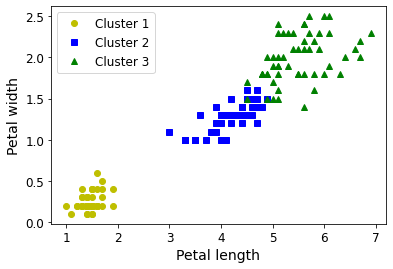

In [9]:
plt.plot(X[y_pred==0, 2], X[y_pred==0, 3], "yo", label="Cluster 1")
plt.plot(X[y_pred==1, 2], X[y_pred==1, 3], "bs", label="Cluster 2")
plt.plot(X[y_pred==2, 2], X[y_pred==2, 3], "g^", label="Cluster 3")
plt.xlabel("Petal length", fontsize=14)
plt.ylabel("Petal width", fontsize=14)
plt.legend(loc="upper left", fontsize=12)
plt.show()

In [10]:
np.sum(y_pred==y)

145

In [11]:
np.sum(y_pred==y) / len(y_pred)

0.9666666666666667

**노트**: 사이킷런 알고리즘이 이따금 업데이트되기 때문에 이 노트북의 결과가 책과 조금 다를 수 있습니다.

## K-평균

먼저 예제 데이터를 생성해 보죠:

In [12]:
from sklearn.datasets import make_blobs

In [13]:
blob_centers = np.array(
    [[ 0.2,  2.3],
     [-1.5 ,  2.3],
     [-2.8,  1.8],
     [-2.8,  2.8],
     [-2.8,  1.3]])
blob_std = np.array([0.4, 0.3, 0.1, 0.1, 0.1])

In [14]:
X, y = make_blobs(n_samples=2000, centers=blob_centers,
                  cluster_std=blob_std, random_state=7)

데이터를 그래프로 그립니다:

In [15]:
def plot_clusters(X, y=None): # 샘플 덩어리 다섯개
    plt.scatter(X[:, 0], X[:, 1], c=y, s=1)
    plt.xlabel("$x_1$", fontsize=14)
    plt.ylabel("$x_2$", fontsize=14, rotation=0)

그림 저장: blobs_plot


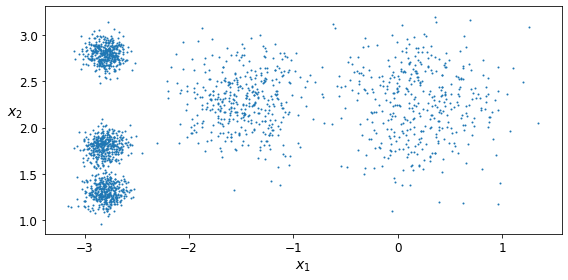

In [16]:
plt.figure(figsize=(8, 4))
plot_clusters(X)
save_fig("blobs_plot")
plt.show()

**훈련과 예측**

이 데이터셋에 K-평균 군집 알고리즘을 훈련해 보겠습니다. 이 알고리즘은 클러스터 중심을 찾고 각 샘플을 가까운 클러스터에 할당합니다:

In [17]:
from sklearn.cluster import KMeans # Kmeans 

In [18]:
k = 5
kmeans = KMeans(n_clusters=k, random_state=42)
y_pred = kmeans.fit_predict(X)

각 샘플은 5개의 클러스터 중 하나에 할당됩니다:

In [19]:
y_pred

array([4, 0, 1, ..., 2, 1, 0], dtype=int32)

In [20]:
y_pred is kmeans.labels_

True

5개의 _센트로이드_ (즉 클러스터 중심)을 찾았습니다:

In [21]:
kmeans.cluster_centers_

array([[-2.80389616,  1.80117999],
       [ 0.20876306,  2.25551336],
       [-2.79290307,  2.79641063],
       [-1.46679593,  2.28585348],
       [-2.80037642,  1.30082566]])

`KMeans` 객체는 훈련한 샘플의 레이블을 가지고 있습니다. 조금 혼동스럽지만 여기에서 샘플의 _레이블_ 은 샘플에 할당한 클러스터의 인덱스입니다:

In [22]:
kmeans.labels_

array([4, 0, 1, ..., 2, 1, 0], dtype=int32)

물론 새로운 샘플의 레이블을 예측할 수 있습니다:

In [23]:
X_new = np.array([[0, 2], [3, 2], [-3, 3], [-3, 2.5]]) #센트로이드 출력 
kmeans.predict(X_new)

array([1, 1, 2, 2], dtype=int32)

**결정 경계**

이 모델의 결정 경계를 그려 보죠. 이 그림은 _보로노이 다이어그램_ 이 됩니다:

In [24]:
def plot_data(X): # 결정 경제 
    plt.plot(X[:, 0], X[:, 1], 'k.', markersize=2)

def plot_centroids(centroids, weights=None, circle_color='w', cross_color='k'):
    if weights is not None:
        centroids = centroids[weights > weights.max() / 10]
    plt.scatter(centroids[:, 0], centroids[:, 1],
                marker='o', s=35, linewidths=8,
                color=circle_color, zorder=10, alpha=0.9)
    plt.scatter(centroids[:, 0], centroids[:, 1],
                marker='x', s=2, linewidths=12, 
                color=cross_color, zorder=11, alpha=1)

def plot_decision_boundaries(clusterer, X, resolution=1000, show_centroids=True,
                             show_xlabels=True, show_ylabels=True):
    mins = X.min(axis=0) - 0.1
    maxs = X.max(axis=0) + 0.1
    xx, yy = np.meshgrid(np.linspace(mins[0], maxs[0], resolution),
                         np.linspace(mins[1], maxs[1], resolution))
    Z = clusterer.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)

    plt.contourf(Z, extent=(mins[0], maxs[0], mins[1], maxs[1]),
                cmap="Pastel2")
    plt.contour(Z, extent=(mins[0], maxs[0], mins[1], maxs[1]),
                linewidths=1, colors='k')
    plot_data(X)
    if show_centroids:
        plot_centroids(clusterer.cluster_centers_)

    if show_xlabels:
        plt.xlabel("$x_1$", fontsize=14)
    else:
        plt.tick_params(labelbottom=False)
    if show_ylabels:
        plt.ylabel("$x_2$", fontsize=14, rotation=0)
    else:
        plt.tick_params(labelleft=False)

그림 저장: voronoi_plot


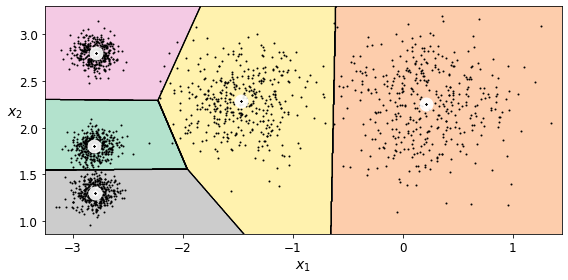

In [25]:
plt.figure(figsize=(8, 4))
plot_decision_boundaries(kmeans, X)
save_fig("voronoi_plot")
plt.show()

나쁘지 않군요! 경계 근처에 있는 일부 샘플은 아마도 잘못 클러스터에 할당된 것 같습니다. 하지만 전반적으로 아주 좋은 것 같습니다.

**하드 군집 _vs_ 소프트 군집**

_하드 군집_ 은 각 샘플에 대해 가장 가까운 클러스터를 선택합니다. 이 대신 샘플에서 5개의 센트로이드까지 거리를 측정하는 것이 나을 수 있습니다. `transform()` 메서드에서 이 거리를 계산합니다:

In [26]:
kmeans.transform(X_new) 

array([[2.81093633, 0.32995317, 2.9042344 , 1.49439034, 2.88633901],
       [5.80730058, 2.80290755, 5.84739223, 4.4759332 , 5.84236351],
       [1.21475352, 3.29399768, 0.29040966, 1.69136631, 1.71086031],
       [0.72581411, 3.21806371, 0.36159148, 1.54808703, 1.21567622]])

이 거리가 샘플과 센트로이드 사이의 유클리드 거리인지 확인할 수 있습니다:

In [27]:
np.linalg.norm(np.tile(X_new, (1, k)).reshape(-1, k, 2) - kmeans.cluster_centers_, axis=2)

array([[2.81093633, 0.32995317, 2.9042344 , 1.49439034, 2.88633901],
       [5.80730058, 2.80290755, 5.84739223, 4.4759332 , 5.84236351],
       [1.21475352, 3.29399768, 0.29040966, 1.69136631, 1.71086031],
       [0.72581411, 3.21806371, 0.36159148, 1.54808703, 1.21567622]])

### K-평균 알고리즘

K-평균 알고리즘은 가장 빠르고 가장 간단한 군집 알고리즘 중 하나입니다:
* 먼저 $k$ 개의 센트로이드를 랜덤하게 초기화합니다: 데이터셋에서 $k$ 개의 샘플을 랜덤하게 선택하고 센트로이드를 그 위치에 놓습니다.
* 수렴할 때까지 다음을 반복합니다(즉, 센트로이드가 더이상 이동하지 않을 때까지):
    * 각 샘플을 가장 가까운 센트로이드에 할당합니다.
    * 센트로이드에 할당된 샘플의 평균으로 센트로이드를 업데이트합니다.

`KMeans` 클래스는 기본적으로 최적화된 알고리즘을 적용합니다. (교육적인 목적으로) 원래 K-평균 알고리즘을 사용하려면 `init="randome"`, `n_init=1`, `algorithm="full"`로 설정해야 합니다. 이 매개변수들은 아래에서 설명하겠습니다.

K-평균 알고리즘을 1, 2, 3회 반복하고 센트로이드가 어떻게 움직이는지 확인해 보겠습니다:

In [28]:
kmeans_iter1 = KMeans(n_clusters=5, init="random", n_init=1, #n_init 서로 다른 군집점 최초 세팅
                      algorithm="full", max_iter=1, random_state=0)
kmeans_iter2 = KMeans(n_clusters=5, init="random", n_init=1,
                      algorithm="full", max_iter=2, random_state=0)
kmeans_iter3 = KMeans(n_clusters=5, init="random", n_init=1,
                      algorithm="full", max_iter=3, random_state=0)
kmeans_iter1.fit(X)
kmeans_iter2.fit(X)
kmeans_iter3.fit(X)

KMeans(algorithm='full', init='random', max_iter=3, n_clusters=5, n_init=1,
       random_state=0)

그래프를 그려 보죠:

그림 저장: kmeans_algorithm_plot


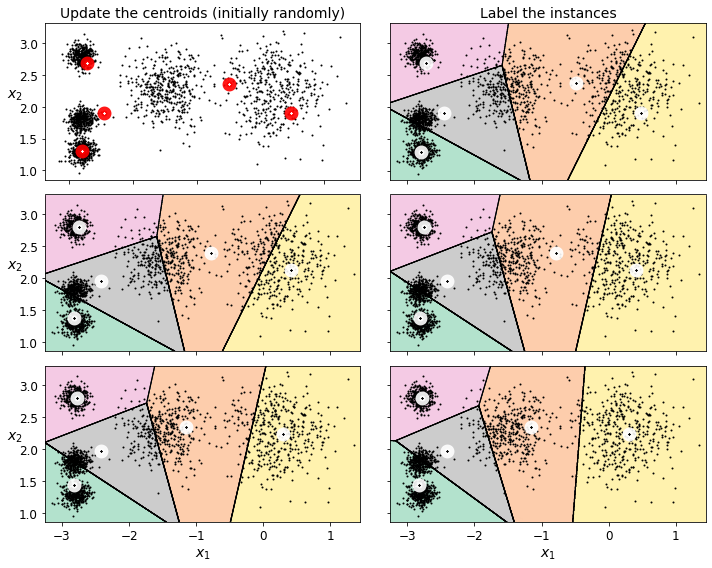

In [29]:
plt.figure(figsize=(10, 8))

plt.subplot(321)
plot_data(X)
plot_centroids(kmeans_iter1.cluster_centers_, circle_color='r', cross_color='w')
plt.ylabel("$x_2$", fontsize=14, rotation=0)
plt.tick_params(labelbottom=False)
plt.title("Update the centroids (initially randomly)", fontsize=14)

plt.subplot(322)
plot_decision_boundaries(kmeans_iter1, X, show_xlabels=False, show_ylabels=False)
plt.title("Label the instances", fontsize=14)

plt.subplot(323)
plot_decision_boundaries(kmeans_iter1, X, show_centroids=False, show_xlabels=False)
plot_centroids(kmeans_iter2.cluster_centers_)

plt.subplot(324)
plot_decision_boundaries(kmeans_iter2, X, show_xlabels=False, show_ylabels=False)

plt.subplot(325)
plot_decision_boundaries(kmeans_iter2, X, show_centroids=False)
plot_centroids(kmeans_iter3.cluster_centers_)

plt.subplot(326)
plot_decision_boundaries(kmeans_iter3, X, show_ylabels=False)

save_fig("kmeans_algorithm_plot")
plt.show()

**K-평균의 변동성**

원래 K-평균 알고리즘에서는 센트로이가 그냥 랜덤하게 초기되고 알고리즘은 단순히 한번씩 반복하여 앞서 본 것처럼 점차 센트로이드를 개선시킵니다.

하지만 이 방식의 문제점은 K-평균을 여러번 (또는 다른 랜덤 시드로) 실행하면 아래에서 보듯이 매우 다른 결과를 얻게됩니다:

In [30]:
def plot_clusterer_comparison(clusterer1, clusterer2, X, title1=None, title2=None):
    clusterer1.fit(X)
    clusterer2.fit(X)

    plt.figure(figsize=(10, 3.2))

    plt.subplot(121)
    plot_decision_boundaries(clusterer1, X)
    if title1:
        plt.title(title1, fontsize=14)

    plt.subplot(122)
    plot_decision_boundaries(clusterer2, X, show_ylabels=False)
    if title2:
        plt.title(title2, fontsize=14)

그림 저장: kmeans_variability_plot


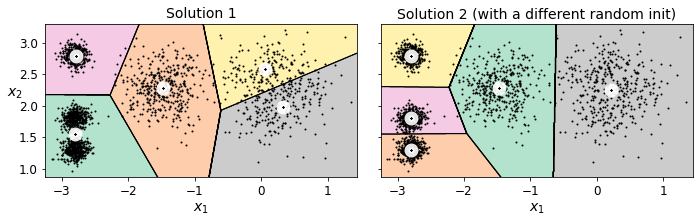

In [31]:
kmeans_rnd_init1 = KMeans(n_clusters=5, init="random", n_init=1,
                          algorithm="full", random_state=2)
kmeans_rnd_init2 = KMeans(n_clusters=5, init="random", n_init=1,
                          algorithm="full", random_state=5)

plot_clusterer_comparison(kmeans_rnd_init1, kmeans_rnd_init2, X,
                          "Solution 1", "Solution 2 (with a different random init)")

save_fig("kmeans_variability_plot")
plt.show()

### 이너셔

최선의 모델을 선택하려면 K-평균 모델의 성능을 평가할 방법이 있어야 합니다. 안타깝지만 군집은 비지도 학습이기 때문에 타깃이 없습니다. 하지만 적어도 각 샘플과 센트로이드 사이의 거리는 측정할 수 있습니다. 이것이 _이너셔_ 지표의 아이디어입니다:

In [32]:
kmeans.inertia_ #이너셔 지표 아이디어 

211.5985372581684

이너셔는 각 훈련 샘플과 가장 가까운 센트로이드 사이의 제곱 거리의 합으로 쉽게 검증할 수 있습니다:

In [33]:
X_dist = kmeans.transform(X)
np.sum(X_dist[np.arange(len(X_dist)), kmeans.labels_]**2)

211.59853725816868

`score()` 메서드는 음의 이너셔를 반환합니다. 왜 음수일까요? 사이킷런의 `score()` 메서드는 항상 " _큰 값이 좋은 것_ " 규칙을 따라야 하기 때문입니다.

In [34]:
kmeans.score(X)

-211.59853725816836

### 다중 초기화

변동성 이슈를 해결하는 한 방법은 단순히 K-평균 알고리즘을 랜덤 초기화를 다르게 하여 여러 번 실행하고 가장 작은 이너셔를 만드는 솔루션을 선택합니다. 예를 들어 앞선 그림에 있는 엉터리 모델 두 개의 이너셔는 다음과 같습니다.

In [35]:
kmeans_rnd_init1.inertia_ # 초기화를 여러번 하고 가장 좋은 솔루션을 선택한다 

219.43539442771396

In [36]:
kmeans_rnd_init2.inertia_

211.5985372581684

여기서 볼 수 있듯이 앞서 훈련한 "좋은" 모델보다 이너셔가 더 높습니다. 즉 더 나쁘다는 것을 의미합니다.

`n_init` 매개변수를 지정하면 사이킷런은 원래 알고리즘을 `n_init` 번 실행하고 이너셔가 가장 작은 솔루션을 선택합니다. 이 매개변수의 기본값은 `n_init=10`입니다.

In [37]:
kmeans_rnd_10_inits = KMeans(n_clusters=5, init="random", n_init=10,
                             algorithm="full", random_state=2)
kmeans_rnd_10_inits.fit(X)

KMeans(algorithm='full', init='random', n_clusters=5, random_state=2)

여기에서 볼 수 있듯이 결국 처음 만들었던 모델을 얻었습니다. 이 모델이 최적의 K-평균 결과로 보입니다($k=5$라고 가정하고 이너셔를 기준으로 했을 때입니다).

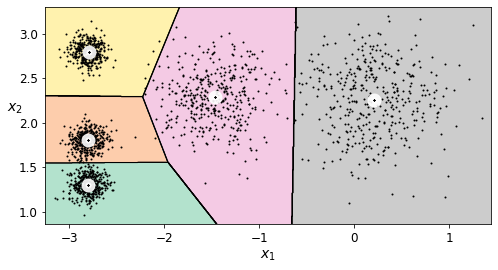

In [38]:
plt.figure(figsize=(8, 4))
plot_decision_boundaries(kmeans_rnd_10_inits, X)
plt.show()

### 센트로이드 초기화 방법

센트로이드를 완전히 랜덤하게 초기화하는 대신 David Arthur와 Sergei Vassilvitskii가 [2006년 논문](https://goo.gl/eNUPw6)에서 제안한 다음 알고리즘을 사용해 초기화하는 것이 더 좋습니다:
* 데이터셋에서 무작위로 균등하게 하나의 센트로이드 $c_1$을 선택합니다.
* $D(\mathbf{x}_i)^2$ / $\sum\limits_{j=1}^{m}{D(\mathbf{x}_j)}^2$의 확률로 샘플 $\mathbf{x}_i$를 새로운 센트로이드 $c_i$로 선택합니다. 여기에서 $D(\mathbf{x}_i)$는 샘플 $\mathbf{x}_i$에서 이미 선택된 가장 가까운 센트로이드까지 거리입니다. 이 확률 분포는 이미 선택한 센트로이드에서 멀리 떨어진 샘플을 센트로이드로 선택할 가능성을 높입니다.
* $k$ 개의 센트로이드를 선택할 때까지 이전 단계를 반복합니다.

K-평균++ 알고리즘의 나머지는 일반 K-평균과 같습니다. 이 초기화 방식을 사용하면 K-평균 알고리즘이 최적의 솔루션에 수렴할 가능성이 훨씬 높아집니다. 따라서 `n_init` 값을 상당히 줄일 수 있습니다. 대부분의 경우 `n_init`를 줄이는 것이 초기화 과정에 추가된 복잡도를 보상합니다.

K-평균++ 초기화를 사용하려면 간단하게 `init="k-means++"`로 지정하면 됩니다(사실 이 값이 기본값입니다):

In [39]:
KMeans()

KMeans()

In [40]:
good_init = np.array([[-3, 3], [-3, 2], [-3, 1], [-1, 2], [0, 2]])
kmeans = KMeans(n_clusters=5, init=good_init, n_init=1, random_state=42)
kmeans.fit(X)
kmeans.inertia_

211.5985372581684

### K-평균 속도 개선

K-평균 알고리즘은 불필요한 거리 계산을 많이 피하는 식으로 속도를 크게 높일 수 있습니다. 이를 위해 삼각 부등식을 사용합니다(3개의 포인트 A, B, C가 있을 때, 거리 AC는 항상 AC ≤ AB + BC를 만족합니다). 그리고 샘플과 센트로이드 사이 거리의 최솟값과 최댓값을 유지합니다(더 자세한 내용은 Charles Elkan의 [2003년 논문](https://www.aaai.org/Papers/ICML/2003/ICML03-022.pdf)을 참고하세요).

Elkan의 K-평균 방식을 사용하려면 `algorithm="elkan"`으로 설정하세요. 이 방법은 희소 행렬을 지원하지 않습니다. 따라서 사이킷런은 밀집 배열에는 `"elkan"`을 사용하고 희소 행렬에는 (기본 K-평균 알고리즘인) `"full`을 사용합니다.

In [41]:
%timeit -n 50 KMeans(algorithm="elkan", random_state=42).fit(X)

The slowest run took 6.16 times longer than the fastest. This could mean that an intermediate result is being cached.
50 loops, best of 5: 68.9 ms per loop


In [42]:
%timeit -n 50 KMeans(algorithm="full", random_state=42).fit(X)

50 loops, best of 5: 43.8 ms per loop


데이터셋이 작기 때문에 여기에서는 큰 차이가 없습니다.

### 미니배치 K-평균

사이킷런은 미니배치를 지원하는 K-평균 방식도 제공합니다(이 [논문](http://www.eecs.tufts.edu/~dsculley/papers/fastkmeans.pdf) 참조):

In [43]:
from sklearn.cluster import MiniBatchKMeans #전체 데이터셋 반복이 아닌 간반복마다 미니배치를 사용해 센트로이드를 조금씩 움직인다. 

In [44]:
minibatch_kmeans = MiniBatchKMeans(n_clusters=5, random_state=42)
minibatch_kmeans.fit(X)

MiniBatchKMeans(n_clusters=5, random_state=42)

In [45]:
minibatch_kmeans.inertia_

211.65239850433215

데이터셋이 메모리에 다 들어가지 못하면 가장 간단한 방법은 이전 장의 점진적 PCA에서 했던 것처럼 `memmap` 클래스를 사용하는 것입니다. 먼저 MNIST 데이터를 로드합니다:

In [46]:
import urllib.request
from sklearn.datasets import fetch_openml

mnist = fetch_openml('mnist_784', version=1)
mnist.target = mnist.target.astype(np.int64)

In [47]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    mnist["data"], mnist["target"], random_state=42)

`memmap`에 데이터를 기록합니다:

In [48]:
filename = "my_mnist.data"
X_mm = np.memmap(filename, dtype='float32', mode='write', shape=X_train.shape)
X_mm[:] = X_train

In [49]:
minibatch_kmeans = MiniBatchKMeans(n_clusters=10, batch_size=10, random_state=42)
minibatch_kmeans.fit(X_mm)

MiniBatchKMeans(batch_size=10, n_clusters=10, random_state=42)

데이터가 너무 커서 `memmap`을 사용할 수 없다면 문제는 더 복잡해집니다. 배치를 로드하는 함수를 먼저 만들어 보죠(실전에서는 디스크에서 데이터를 로드합니다):

In [50]:
def load_next_batch(batch_size):
    return X[np.random.choice(len(X), batch_size, replace=False)]

한 번에 하나의 배치를 모델에 주입하여 훈련할 수 있습니다. 또한 여러 번 초기화를 수행하고 이너셔가 가장 낮은 모델을 선택합니다:

In [51]:
np.random.seed(42)

In [52]:
k = 5
n_init = 10
n_iterations = 100
batch_size = 100
init_size = 500  # K-Means++ 초기화를 위해 충분한 데이터 전달
evaluate_on_last_n_iters = 10

best_kmeans = None

for init in range(n_init):
    minibatch_kmeans = MiniBatchKMeans(n_clusters=k, init_size=init_size)
    X_init = load_next_batch(init_size)
    minibatch_kmeans.partial_fit(X_init)

    minibatch_kmeans.sum_inertia_ = 0
    for iteration in range(n_iterations):
        X_batch = load_next_batch(batch_size)
        minibatch_kmeans.partial_fit(X_batch)
        if iteration >= n_iterations - evaluate_on_last_n_iters:
            minibatch_kmeans.sum_inertia_ += minibatch_kmeans.inertia_

    if (best_kmeans is None or
        minibatch_kmeans.sum_inertia_ < best_kmeans.sum_inertia_):
        best_kmeans = minibatch_kmeans

In [53]:
best_kmeans.score(X)

-211.62571878891146

미니배치 K-평균이 일반 K-평균보다 훨씬 빠릅니다:

In [54]:
%timeit KMeans(n_clusters=5, random_state=42).fit(X)

The slowest run took 6.23 times longer than the fastest. This could mean that an intermediate result is being cached.
1 loop, best of 5: 117 ms per loop


In [55]:
%timeit MiniBatchKMeans(n_clusters=5, random_state=42).fit(X)

10 loops, best of 5: 36.2 ms per loop


*훨씬* 빠르군요! 하지만 성능이 낮은 (즉 이너셔가 높은) 경우가 많습니다. _k_ 가 증가할수록 더 그렇습니다. 미니배치 K-평균과 일반 K-평균 사이에 이너셔와 훈련 시간을 그래프로 나타내 보겠습니다:

In [56]:
from timeit import timeit

In [ ]:
times = np.empty((100, 2))
inertias = np.empty((100, 2))
for k in range(1, 101):
    kmeans_ = KMeans(n_clusters=k, random_state=42)
    minibatch_kmeans = MiniBatchKMeans(n_clusters=k, random_state=42)
    print("\r{}/{}".format(k, 100), end="")
    times[k-1, 0] = timeit("kmeans_.fit(X)", number=10, globals=globals())
    times[k-1, 1]  = timeit("minibatch_kmeans.fit(X)", number=10, globals=globals())
    inertias[k-1, 0] = kmeans_.inertia_
    inertias[k-1, 1] = minibatch_kmeans.inertia_

82/100

In [ ]:
plt.figure(figsize=(10,4))

plt.subplot(121)
plt.plot(range(1, 101), inertias[:, 0], "r--", label="K-Means")
plt.plot(range(1, 101), inertias[:, 1], "b.-", label="Mini-batch K-Means")
plt.xlabel("$k$", fontsize=16)
plt.title("Inertia", fontsize=14)
plt.legend(fontsize=14)
plt.axis([1, 100, 0, 100])

plt.subplot(122)
plt.plot(range(1, 101), times[:, 0], "r--", label="K-Means")
plt.plot(range(1, 101), times[:, 1], "b.-", label="Mini-batch K-Means")
plt.xlabel("$k$", fontsize=16)
plt.title("Training time (seconds)", fontsize=14)
plt.axis([1, 100, 0, 6])

save_fig("minibatch_kmeans_vs_kmeans")
plt.show()

### 최적의 클러스터 개수 찾기

클러스터 개수가 5보다 작거나 크게 지정하면 어떨까요?

In [ ]:
kmeans_k3 = KMeans(n_clusters=3, random_state=42) #최적 클러스터 개수는 이너셔가 꺾이는 엘보지점이 적당하다.
kmeans_k8 = KMeans(n_clusters=8, random_state=42)

plot_clusterer_comparison(kmeans_k3, kmeans_k8, X, "$k=3$", "$k=8$")
save_fig("bad_n_clusters_plot")
plt.show()

두 모델 모두 좋아 보이지 않는군요. 이너셔는 어떨까요?

In [ ]:
kmeans_k3.inertia_

In [ ]:
kmeans_k8.inertia_

$k$가 증가할수록 이너셔가 줄어들기 때문에 단순히 이너셔가 작은 $k$를 선택할 수 없군요. 실제 클러스터가 많을수록 샘플은 인접한 센트로이드에 더 가깝습니다. 따라서 이너셔가 더 작습니다. 하지만 $k$에 대한 이너셔를 그래프로 그리고 결과 그래프를 조사해 볼 수 있습니다:

In [ ]:
kmeans_per_k = [KMeans(n_clusters=k, random_state=42).fit(X)
                for k in range(1, 10)]
inertias = [model.inertia_ for model in kmeans_per_k]

In [ ]:
plt.figure(figsize=(8, 3.5))
plt.plot(range(1, 10), inertias, "bo-")
plt.xlabel("$k$", fontsize=14)
plt.ylabel("Inertia", fontsize=14)
plt.annotate('Elbow',
             xy=(4, inertias[3]),
             xytext=(0.55, 0.55),
             textcoords='figure fraction',
             fontsize=16,
             arrowprops=dict(facecolor='black', shrink=0.1)
            )
plt.axis([1, 8.5, 0, 1300])
save_fig("inertia_vs_k_plot")
plt.show()

여기에서 볼 수 있듯이 $k=4$에서 엘보우가 있습니다. 이 값보다 클러스터가 작으면 나쁘다는 뜻입니다. 이보다 더 많으면 크게 도움이 되지 않고 배로 늘려도 그렇습니다. 따라서 $k=4$가 아주 좋은 선택입니다. 물론 이 예제에서는 이 값이 완벽하지 않습니다. 왼쪽 아래 두 클러스터가 하나의 클러스터로 간주되었지만 꽤 좋은 군집 결과입니다.

In [ ]:
plot_decision_boundaries(kmeans_per_k[4-1], X)
plt.show()

또 다른 방법은 모든 샘플에 대한 _실루엣 계수_ 의 평균인 _실루엣 점수_ 입니다. 한 샘플의 실루엣 계수는 $(b - a)/\max(a, b)$입니다. 여기에서 $a$는 같은 클러스터에 있는 다른 샘플까지의 평균 거리입니다(이를 _클러스터 내부 평균 거리_ 라고 합니다). $b$는 가장 가까운 클러스터까지 평균 거리입니다. 즉 가장 가까운 클러스터(샘플 자신의 클러스터를 제외하고 $b$를 최소화하는 클러스터)의 샘플까지 평균 거리입니다. 실루엣 계수는 -1에서 +1 사이 값을 가집니다. +1에 가까우면 샘플이 다른 클러스터로부터 떨어져 자신의 클러스터 안에 잘 있다는 것을 의미합니다.0에 가까우면 클러스터 경계에 가깝다는 의미입니다. -1에 가까우면 샘플이 잘못된 클러스터에 할당되었을지 모릅니다.

$k$에 대한 실루엣 점수를 그래프로 그려보죠:

In [ ]:
from sklearn.metrics import silhouette_score

In [ ]:
silhouette_score(X, kmeans.labels_)

In [ ]:
silhouette_scores = [silhouette_score(X, model.labels_)
                     for model in kmeans_per_k[1:]]

In [ ]:
plt.figure(figsize=(8, 3))
plt.plot(range(2, 10), silhouette_scores, "bo-")
plt.xlabel("$k$", fontsize=14)
plt.ylabel("Silhouette score", fontsize=14)
plt.axis([1.8, 8.5, 0.55, 0.7])
save_fig("silhouette_score_vs_k_plot")
plt.show()

여기에서 볼 수 있듯이 이 그래프는 이전보다 정보가 더 풍부합니다. 특히 $k=4$가 매우 좋은 선택이지만 $k=5$도 꽤 괜찮은 선택이라는 것을 보여줍니다.

모든 샘플의 실루엣 계수를 할당된 클러스터와 실루엣 값으로 정렬하여 그리면 훨씬 많은 정보를 얻을 수 있습니다. 이를 _실루엣 다이어그램_ 이라고 합니다:

In [ ]:
from sklearn.metrics import silhouette_samples
from matplotlib.ticker import FixedLocator, FixedFormatter

plt.figure(figsize=(11, 9))

for k in (3, 4, 5, 6):
    plt.subplot(2, 2, k - 2)
    
    y_pred = kmeans_per_k[k - 1].labels_
    silhouette_coefficients = silhouette_samples(X, y_pred)

    padding = len(X) // 30
    pos = padding
    ticks = []
    for i in range(k):
        coeffs = silhouette_coefficients[y_pred == i]
        coeffs.sort()

        color = mpl.cm.Spectral(i / k)
        plt.fill_betweenx(np.arange(pos, pos + len(coeffs)), 0, coeffs,
                          facecolor=color, edgecolor=color, alpha=0.7)
        ticks.append(pos + len(coeffs) // 2)
        pos += len(coeffs) + padding

    plt.gca().yaxis.set_major_locator(FixedLocator(ticks))
    plt.gca().yaxis.set_major_formatter(FixedFormatter(range(k)))
    if k in (3, 5):
        plt.ylabel("Cluster")
    
    if k in (5, 6):
        plt.gca().set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])
        plt.xlabel("Silhouette Coefficient")
    else:
        plt.tick_params(labelbottom=False)

    plt.axvline(x=silhouette_scores[k - 2], color="red", linestyle="--")
    plt.title("$k={}$".format(k), fontsize=16)

save_fig("silhouette_analysis_plot")
plt.show()

여기에서 볼 수 있듯이 $k=5$가 가장 좋은 선택입니다. 모든 클러스터의 크기가 거의 동일하고 평균 실루엣 점수를 나타내는 파선을 모두 넘었습니다.

## K-평균의 한계

In [ ]:
X1, y1 = make_blobs(n_samples=1000, centers=((4, -4), (0, 0)), random_state=42) # 클러스터의 밀집도와 방향이 다르면 솔루션 결과가 좋지 않다.
X1 = X1.dot(np.array([[0.374, 0.95], [0.732, 0.598]]))
X2, y2 = make_blobs(n_samples=250, centers=1, random_state=42)
X2 = X2 + [6, -8]
X = np.r_[X1, X2]
y = np.r_[y1, y2]

In [ ]:
plot_clusters(X)

In [ ]:
kmeans_good = KMeans(n_clusters=3, init=np.array([[-1.5, 2.5], [0.5, 0], [4, 0]]), n_init=1, random_state=42)
kmeans_bad = KMeans(n_clusters=3, random_state=42)
kmeans_good.fit(X)
kmeans_bad.fit(X)

In [ ]:
plt.figure(figsize=(10, 3.2))

plt.subplot(121)
plot_decision_boundaries(kmeans_good, X)
plt.title("Inertia = {:.1f}".format(kmeans_good.inertia_), fontsize=14)

plt.subplot(122)
plot_decision_boundaries(kmeans_bad, X, show_ylabels=False)
plt.title("Inertia = {:.1f}".format(kmeans_bad.inertia_), fontsize=14)

save_fig("bad_kmeans_plot")
plt.show()

## 군집을 사용한 이미지 분할

In [ ]:
# 무당벌레 이미지를 다운로드합니다 # 군집을 통한 이미지 분할 
images_path = os.path.join(PROJECT_ROOT_DIR, "images", "unsupervised_learning")
os.makedirs(images_path, exist_ok=True)
DOWNLOAD_ROOT = "https://raw.githubusercontent.com/rickiepark/handson-ml2/master/"
filename = "ladybug.png"
print("Downloading", filename)
url = DOWNLOAD_ROOT + "images/unsupervised_learning/" + filename
urllib.request.urlretrieve(url, os.path.join(images_path, filename))

In [ ]:
from matplotlib.image import imread
image = imread(os.path.join(images_path, filename))
image.shape

In [ ]:
X = image.reshape(-1, 3)
kmeans = KMeans(n_clusters=8, random_state=42).fit(X)
segmented_img = kmeans.cluster_centers_[kmeans.labels_]
segmented_img = segmented_img.reshape(image.shape)

In [ ]:
segmented_imgs = []
n_colors = (10, 8, 6, 4, 2)
for n_clusters in n_colors:
    kmeans = KMeans(n_clusters=n_clusters, random_state=42).fit(X)
    segmented_img = kmeans.cluster_centers_[kmeans.labels_]
    segmented_imgs.append(segmented_img.reshape(image.shape))

In [ ]:
plt.figure(figsize=(10,5))
plt.subplots_adjust(wspace=0.05, hspace=0.1)

plt.subplot(231)
plt.imshow(image)
plt.title("Original image")
plt.axis('off')

for idx, n_clusters in enumerate(n_colors):
    plt.subplot(232 + idx)
    plt.imshow(segmented_imgs[idx])
    plt.title("{} colors".format(n_clusters))
    plt.axis('off')

save_fig('image_segmentation_diagram', tight_layout=False)
plt.show()

## 군집을 사용한 전처리

MNIST와 유사하게 숫자 0에서 9까지 8x8 흑백 이미지 1,797개로 이루어진 _숫자 데이터셋_ 을 다루어 보겠습니다.

In [ ]:
from sklearn.datasets import load_digits #군집을 이용한 전처리 진행 

In [ ]:
X_digits, y_digits = load_digits(return_X_y=True)

훈련 세트와 테스트 세트로 나눕니다:

In [ ]:
from sklearn.model_selection import train_test_split

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X_digits, y_digits, random_state=42)

로지스틱 회귀 모델을 훈련하고 테스트 세트에서 평가합니다:

In [ ]:
from sklearn.linear_model import LogisticRegression

In [ ]:
log_reg = LogisticRegression(multi_class="ovr", solver="lbfgs", max_iter=5000, random_state=42)
log_reg.fit(X_train, y_train)

In [ ]:
log_reg_score = log_reg.score(X_test, y_test)
log_reg_score

좋습니다. 기본 모델의 정확도는 96.89%입니다. 이제 K-평균을 전처리 단계로 사용해 더 향상할 수 있는지 알아 보죠. 훈련 세트를 50개의 클러스터로 만들고 이미지를 이 클러스터까지 거리로 바꾼 다음 로지스틱 회귀 모델을 적용하는 파이프라인을 만듭니다:

In [ ]:
from sklearn.pipeline import Pipeline

In [ ]:
pipeline = Pipeline([
    ("kmeans", KMeans(n_clusters=50, random_state=42)),
    ("log_reg", LogisticRegression(multi_class="ovr", solver="lbfgs", max_iter=5000, random_state=42)),
])
pipeline.fit(X_train, y_train)

In [ ]:
pipeline_score = pipeline.score(X_test, y_test)
pipeline_score

얼마나 오차가 감소했나요?

In [ ]:
1 - (1 - pipeline_score) / (1 - log_reg_score)

어떤가요? 오차율을 35%나 줄였습니다! 하지만 클러스터 개수 $k$를 임의로 결정했습니다. 이 보다 더 나은 방법이 있겠죠. K-평균을 분류 파이프라인에서 전처리 단계로 사용했기 때문에 좋은 $k$ 값을 찾는 것은 이전보다 더 쉽습니다. 실루엣 분석을 수행하거나 이너셔를 최소화할 필요가 없습니다. 가장 좋은 $k$ 값은 가장 좋은 분류 성능을 내는 것입니다.

In [ ]:
from sklearn.model_selection import GridSearchCV

**경고**: 사용하는 하드웨어에 따라 다음 셀을 실행하는데 20분 또는 그 이상 걸릴 수 있습니다.

In [ ]:
param_grid = dict(kmeans__n_clusters=range(2, 100))
grid_clf = GridSearchCV(pipeline, param_grid, cv=3, verbose=2)
grid_clf.fit(X_train, y_train)

최고의 클러스터 개수를 확인해 보죠:

In [ ]:
grid_clf.best_params_

In [ ]:
grid_clf.score(X_test, y_test)

## 군집을 사용한 준지도 학습

군집의 또 다른 사용처는 레이블이 없는 샘플이 많고 레이블이 있는 샘플이 적을 때 사용하는 준지도 학습입니다.

레이블을 가진 샘플이 50개만 있을 때 로지스틱 회귀 모델의 성능을 확인해 보죠:

In [ ]:
n_labeled = 50 # 군집을 이용한 이미지 분할 진행, 클러스터를 나눔을 통해서 이미지를 구성할 수 있다. 

In [ ]:
log_reg = LogisticRegression(multi_class="ovr", solver="lbfgs", random_state=42)
log_reg.fit(X_train[:n_labeled], y_train[:n_labeled])
log_reg.score(X_test, y_test)

당연히 이전보다 훨씬 낮네요. 어떻게 더 향상할 수 있는지 알아 보겠습니다. 먼저 훈련 세트를 클러스터 50개로 군집합니다. 그다음 각 클러스터에서 센트로이드에 가장 가까운 이미지를 찾습니다. 이 이미지를 대표 이미지라고 부르겠습니다:

In [ ]:
k = 50

In [ ]:
kmeans = KMeans(n_clusters=k, random_state=42)
X_digits_dist = kmeans.fit_transform(X_train)
representative_digit_idx = np.argmin(X_digits_dist, axis=0)
X_representative_digits = X_train[representative_digit_idx]

대표 이미지를 출력하고 수동으로 레이블을 매겨 보겠습니다:

In [ ]:
plt.figure(figsize=(8, 2))
for index, X_representative_digit in enumerate(X_representative_digits):
    plt.subplot(k // 10, 10, index + 1)
    plt.imshow(X_representative_digit.reshape(8, 8), cmap="binary", interpolation="bilinear")
    plt.axis('off')

save_fig("representative_images_diagram", tight_layout=False)
plt.show()

In [ ]:
y_train[representative_digit_idx]

In [ ]:
y_representative_digits = np.array([
    0, 1, 3, 2, 7, 6, 4, 6, 9, 5,
    1, 2, 9, 5, 2, 7, 8, 1, 8, 6,
    3, 1, 5, 4, 5, 4, 0, 3, 2, 6,
    1, 7, 7, 9, 1, 8, 6, 5, 4, 8,
    5, 3, 3, 6, 7, 9, 7, 8, 4, 9])

이 데이터셋은 레이블이 있는 샘플이 50개뿐이지만 완전히 랜덤한 샘플이 아니라 각 샘플은 클러스터의 대표 이미지입니다. 성능이 더 나은지 확인해 보죠:

In [ ]:
log_reg = LogisticRegression(multi_class="ovr", solver="lbfgs", max_iter=5000, random_state=42)
log_reg.fit(X_representative_digits, y_representative_digits)
log_reg.score(X_test, y_test)

와우! 83.3%에서 91.3%로 확 올랐네요. 여전히 50개의 샘플로만 모델을 훈련했습니다. 샘플에 레이블을 다는 것은 비용이 많이 들고 어려운 작업입니다. 특히 전문가가 수동으로 작업할 때 그렇습니다. 이 때 랜덤한 샘플보다는 대표 샘플에 레이블을 다는 것이 좋은 생각입니다.

하지만 더 향상시킬 수 있습니다. 이 레이블을 같은 클러스터에 있는 다른 모든 샘플에 전파하면 어떨까요?

In [ ]:
y_train_propagated = np.empty(len(X_train), dtype=np.int32)
for i in range(k):
    y_train_propagated[kmeans.labels_==i] = y_representative_digits[i]

In [ ]:
log_reg = LogisticRegression(multi_class="ovr", solver="lbfgs", max_iter=5000, random_state=42)
log_reg.fit(X_train, y_train_propagated)

In [ ]:
log_reg.score(X_test, y_test)

아주 조금 정확도를 높였습니다. 없는 것보다는 낫지만 센트로이드에 가까운 샘플에만 레이블을 전파하는 것이 나을지 모릅니다. 왜냐하면 전체 클러스터에 전파하면 일부 이상치를 포함하기 때문입니다. 레이블을 센트로이드에 가까운 75번째 백분위수까지만 전파해보죠:

In [ ]:
percentile_closest = 75

X_cluster_dist = X_digits_dist[np.arange(len(X_train)), kmeans.labels_]
for i in range(k):
    in_cluster = (kmeans.labels_ == i)
    cluster_dist = X_cluster_dist[in_cluster]
    cutoff_distance = np.percentile(cluster_dist, percentile_closest)
    above_cutoff = (X_cluster_dist > cutoff_distance)
    X_cluster_dist[in_cluster & above_cutoff] = -1

In [ ]:
partially_propagated = (X_cluster_dist != -1)
X_train_partially_propagated = X_train[partially_propagated]
y_train_partially_propagated = y_train_propagated[partially_propagated]

In [ ]:
log_reg = LogisticRegression(multi_class="ovr", solver="lbfgs", max_iter=5000, random_state=42)
log_reg.fit(X_train_partially_propagated, y_train_partially_propagated)

In [ ]:
log_reg.score(X_test, y_test)

조금 더 낫네요. 레이블된 샘플 50개(클래스당 평균 5개 샘플!)만 가지고 92.7% 성능을 달성했습니다. 레이블된 전체 숫자 데이터셋에서 훈련한 로지스틱 회귀의 성능(96.9%)과 매우 비슷합니다.

이는 전파된 레이블이 실제로 매우 좋기 때문입니다. 이 정확도는 96%에 가깝습니다:

In [ ]:
np.mean(y_train_partially_propagated == y_train[partially_propagated])

*능동 학습*을 여러 번 반복할 수 있습니다:
1. 분류기의 확신이 부족한 샘플에 수동으로 레이블을 부여합니다. 가능하면 다른 클러스터에서 샘플을 선택합니다.
2. 추가된 레이블을 사용해 새로운 모델을 훈련합니다.

## DBSCAN

In [ ]:
from sklearn.datasets import make_moons # 연속적인 지역을 클러스터로 정의 하는 알고리즘 

In [ ]:
X, y = make_moons(n_samples=1000, noise=0.05, random_state=42)

In [ ]:
from sklearn.cluster import DBSCAN

In [ ]:
dbscan = DBSCAN(eps=0.05, min_samples=5)
dbscan.fit(X)

In [ ]:
dbscan.labels_[:10]

In [ ]:
len(dbscan.core_sample_indices_)

In [ ]:
dbscan.core_sample_indices_[:10]

In [ ]:
dbscan.components_[:3]

In [ ]:
np.unique(dbscan.labels_)

In [ ]:
dbscan2 = DBSCAN(eps=0.2)
dbscan2.fit(X)

In [ ]:
def plot_dbscan(dbscan, X, size, show_xlabels=True, show_ylabels=True):
    core_mask = np.zeros_like(dbscan.labels_, dtype=bool)
    core_mask[dbscan.core_sample_indices_] = True
    anomalies_mask = dbscan.labels_ == -1
    non_core_mask = ~(core_mask | anomalies_mask)

    cores = dbscan.components_
    anomalies = X[anomalies_mask]
    non_cores = X[non_core_mask]
    
    plt.scatter(cores[:, 0], cores[:, 1],
                c=dbscan.labels_[core_mask], marker='o', s=size, cmap="Paired")
    plt.scatter(cores[:, 0], cores[:, 1], marker='*', s=20, c=dbscan.labels_[core_mask])
    plt.scatter(anomalies[:, 0], anomalies[:, 1],
                c="r", marker="x", s=100)
    plt.scatter(non_cores[:, 0], non_cores[:, 1], c=dbscan.labels_[non_core_mask], marker=".")
    if show_xlabels:
        plt.xlabel("$x_1$", fontsize=14)
    else:
        plt.tick_params(labelbottom=False)
    if show_ylabels:
        plt.ylabel("$x_2$", fontsize=14, rotation=0)
    else:
        plt.tick_params(labelleft=False)
    plt.title("eps={:.2f}, min_samples={}".format(dbscan.eps, dbscan.min_samples), fontsize=14)

In [ ]:
plt.figure(figsize=(9, 3.2))

plt.subplot(121)
plot_dbscan(dbscan, X, size=100)

plt.subplot(122)
plot_dbscan(dbscan2, X, size=600, show_ylabels=False)

save_fig("dbscan_plot")
plt.show()


In [ ]:
dbscan = dbscan2

In [ ]:
from sklearn.neighbors import KNeighborsClassifier

In [ ]:
knn = KNeighborsClassifier(n_neighbors=50)
knn.fit(dbscan.components_, dbscan.labels_[dbscan.core_sample_indices_])

In [ ]:
X_new = np.array([[-0.5, 0], [0, 0.5], [1, -0.1], [2, 1]])
knn.predict(X_new)

In [ ]:
knn.predict_proba(X_new)

In [ ]:
plt.figure(figsize=(6, 3))
plot_decision_boundaries(knn, X, show_centroids=False)
plt.scatter(X_new[:, 0], X_new[:, 1], c="b", marker="+", s=200, zorder=10)
save_fig("cluster_classification_plot")
plt.show()

In [ ]:
y_dist, y_pred_idx = knn.kneighbors(X_new, n_neighbors=1)
y_pred = dbscan.labels_[dbscan.core_sample_indices_][y_pred_idx]
y_pred[y_dist > 0.2] = -1
y_pred.ravel()

## 다른 군집 알고리즘

### 스펙트럼 군집

In [ ]:
from sklearn.cluster import SpectralClustering #샘플사이의 유사도 행렬을 받아 저차원 임베딩을 진행 

In [ ]:
sc1 = SpectralClustering(n_clusters=2, gamma=100, random_state=42)
sc1.fit(X)

In [ ]:
sc2 = SpectralClustering(n_clusters=2, gamma=1, random_state=42)
sc2.fit(X)

In [ ]:
np.percentile(sc1.affinity_matrix_, 95)

In [ ]:
def plot_spectral_clustering(sc, X, size, alpha, show_xlabels=True, show_ylabels=True):
    plt.scatter(X[:, 0], X[:, 1], marker='o', s=size, c='gray', cmap="Paired", alpha=alpha)
    plt.scatter(X[:, 0], X[:, 1], marker='o', s=30, c='w')
    plt.scatter(X[:, 0], X[:, 1], marker='.', s=10, c=sc.labels_, cmap="Paired")
    
    if show_xlabels:
        plt.xlabel("$x_1$", fontsize=14)
    else:
        plt.tick_params(labelbottom=False)
    if show_ylabels:
        plt.ylabel("$x_2$", fontsize=14, rotation=0)
    else:
        plt.tick_params(labelleft=False)
    plt.title("RBF gamma={}".format(sc.gamma), fontsize=14)

In [ ]:
plt.figure(figsize=(9, 3.2))

plt.subplot(121)
plot_spectral_clustering(sc1, X, size=500, alpha=0.1)

plt.subplot(122)
plot_spectral_clustering(sc2, X, size=4000, alpha=0.01, show_ylabels=False)

plt.show()


### 병합 군집

In [ ]:
from sklearn.cluster import AgglomerativeClustering

In [ ]:
X = np.array([0, 2, 5, 8.5]).reshape(-1, 1)
agg = AgglomerativeClustering(linkage="complete").fit(X)

In [ ]:
def learned_parameters(estimator):
    return [attrib for attrib in dir(estimator)
            if attrib.endswith("_") and not attrib.startswith("_")]

In [ ]:
learned_parameters(agg)

In [ ]:
agg.children_

# 가우시안 혼합

In [ ]:
X1, y1 = make_blobs(n_samples=1000, centers=((4, -4), (0, 0)), random_state=42) # 기댓값- 최대화 알고리즘을 이용한 가우시안 혼합 알고리즘 
X1 = X1.dot(np.array([[0.374, 0.95], [0.732, 0.598]]))
X2, y2 = make_blobs(n_samples=250, centers=1, random_state=42)
X2 = X2 + [6, -8]
X = np.r_[X1, X2]
y = np.r_[y1, y2]

이 데이터셋으로 가우시안 혼합 모델을 훈련해 보죠:

In [ ]:
from sklearn.mixture import GaussianMixture

In [ ]:
gm = GaussianMixture(n_components=3, n_init=10, random_state=42)
gm.fit(X)

EM 알고리즘이 추정한 파라미터를 확인해 보죠:

In [ ]:
gm.weights_

In [ ]:
gm.means_

In [ ]:
gm.covariances_

이 알고리즘이 실제로 수렴했나요?

In [ ]:
gm.converged_

네 좋습니다. 몇 번 반복했나요?

In [ ]:
gm.n_iter_

이제 이 모델을 사용해 각 샘플이 속한 클러스터(하드 군집)나 클러스터에 속할 확률을 예측할 수 있습니다. 이를 위해 `predict()` 메서드나 `predict_proba()` 메서드를 사용합니다:

In [ ]:
gm.predict(X)

In [ ]:
gm.predict_proba(X)

이 모델은 생성 모델입니다. 따라서 새로운 샘플(과 레이블)을 생성할 수 있습니다:

In [ ]:
X_new, y_new = gm.sample(6)
X_new

In [ ]:
y_new

각 클러스터에서 순서대로 샘플링되었습니다.

`score_samples()` 메서드를 사용해 로그 _확률 밀도 함수_ (PDF)를 추정할 수도 있습니다.

In [ ]:
gm.score_samples(X)

전체 공간에 대해 이 PDF를 적분하면 1이 되는지 확인해 보죠. 클러스터 주위로 큰 사각형을 정하고 작은 사각형의 그리드로 자릅니다. 그다음 작은 사각형에서 샘플이 생성될 확률의 근삿값을 계산해 보죠(작은 사각형의 면적과 PDF를 곱하고 이 확률을 모두 더합니다). 결괏값은 1에 매우 가깝습니다:

In [ ]:
resolution = 100
grid = np.arange(-10, 10, 1 / resolution)
xx, yy = np.meshgrid(grid, grid)
X_full = np.vstack([xx.ravel(), yy.ravel()]).T

pdf = np.exp(gm.score_samples(X_full))
pdf_probas = pdf * (1 / resolution) ** 2
pdf_probas.sum()

만들어진 결정 경계(파선)와 밀도 등고선을 그려보죠:

In [ ]:
from matplotlib.colors import LogNorm #이 등고선에서 밀도가 적은 곳은 이상치 이다. 

def plot_gaussian_mixture(clusterer, X, resolution=1000, show_ylabels=True):
    mins = X.min(axis=0) - 0.1
    maxs = X.max(axis=0) + 0.1
    xx, yy = np.meshgrid(np.linspace(mins[0], maxs[0], resolution),
                         np.linspace(mins[1], maxs[1], resolution))
    Z = -clusterer.score_samples(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)

    plt.contourf(xx, yy, Z,
                 norm=LogNorm(vmin=1.0, vmax=30.0),
                 levels=np.logspace(0, 2, 12))
    plt.contour(xx, yy, Z,
                norm=LogNorm(vmin=1.0, vmax=30.0),
                levels=np.logspace(0, 2, 12),
                linewidths=1, colors='k')

    Z = clusterer.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    plt.contour(xx, yy, Z,
                linewidths=2, colors='r', linestyles='dashed')
    
    plt.plot(X[:, 0], X[:, 1], 'k.', markersize=2)
    plot_centroids(clusterer.means_, clusterer.weights_)

    plt.xlabel("$x_1$", fontsize=14)
    if show_ylabels:
        plt.ylabel("$x_2$", fontsize=14, rotation=0)
    else:
        plt.tick_params(labelleft=False)

In [ ]:
plt.figure(figsize=(8, 4))

plot_gaussian_mixture(gm, X)

save_fig("gaussian_mixtures_plot")
plt.show()

`covariance_type` 매개변수를 사용해 이 알고리즘이 찾을 공분산 행렬을 제한할 수 있습니다.
* `"full"`(기본값): 제약이 없습니다. 모든 클러스터가 어떤 크기의 타원도 될 수 있습니다.
* `"tied"`: 모든 클러스터가 동일하지만 어떤 타원도 가능합니다(즉, 공분산 행렬을 공유합니다).
* `"spherical"`: 모든 클러스터가 원형이지만 지름은 다를 수 있습니다(즉, 분산이 다릅니다).
* `"diag"`: 클러스터는 어떤 크기의 타원도 될 수 있지만 타원은 축에 나란해야 합니다(즉, 공분산 행렬이 대각 행렬입니다).

In [ ]:
gm_full = GaussianMixture(n_components=3, n_init=10, covariance_type="full", random_state=42)
gm_tied = GaussianMixture(n_components=3, n_init=10, covariance_type="tied", random_state=42)
gm_spherical = GaussianMixture(n_components=3, n_init=10, covariance_type="spherical", random_state=42)
gm_diag = GaussianMixture(n_components=3, n_init=10, covariance_type="diag", random_state=42)
gm_full.fit(X)
gm_tied.fit(X)
gm_spherical.fit(X)
gm_diag.fit(X)

In [ ]:
def compare_gaussian_mixtures(gm1, gm2, X):
    plt.figure(figsize=(9, 4))

    plt.subplot(121)
    plot_gaussian_mixture(gm1, X)
    plt.title('covariance_type="{}"'.format(gm1.covariance_type), fontsize=14)

    plt.subplot(122)
    plot_gaussian_mixture(gm2, X, show_ylabels=False)
    plt.title('covariance_type="{}"'.format(gm2.covariance_type), fontsize=14)


In [ ]:
compare_gaussian_mixtures(gm_tied, gm_spherical, X)

save_fig("covariance_type_plot")
plt.show()

In [ ]:
compare_gaussian_mixtures(gm_full, gm_diag, X)
plt.tight_layout()
plt.show()

사이킷런 예제:
![scikit-learn-docs](https://scikit-learn.org/stable/_images/sphx_glr_plot_gmm_covariances_0011.png)

## 가우시안 혼합을 사용한 이상치 탐지

가우시안 혼합을 _이상치 탐지_ 에 사용할 수 있습니다: 밀도가 낮은 지역에 있는 샘플을 이상치로 생각할 수 있습니다. 사용할 밀도 임곗값을 결정해야 합니다. 예를 들어 한 제조 회사에서 결함 제품을 감지하려고 합니다. 결함 제품의 비율은 잘 알려져 있습니다. 이 비율이 4%라고 하면 밀도 임곗값을 이 값으로 지정하여 임계 밀도보다 낮은 지역에 있는 샘플을 얻을 수 있습니다:

In [ ]:
densities = gm.score_samples(X)
density_threshold = np.percentile(densities, 4)
anomalies = X[densities < density_threshold]

In [ ]:
plt.figure(figsize=(8, 4))

plot_gaussian_mixture(gm, X)
plt.scatter(anomalies[:, 0], anomalies[:, 1], color='r', marker='*')
plt.ylim(top=5.1)

save_fig("mixture_anomaly_detection_plot")
plt.show()

## 모델 선택

이너셔나 실루엣 점수는 모두 원형 클러스터를 가정하기 때문에 가우시안 혼합 모델에 사용할 수 없습니다. 대신 BIC(Bayesian Information Criterion)나 AIC(Akaike Information Criterion) 같은 이론적 정보 기준을 최소화하는 모델을 찾을 수 있습니다:

${BIC} = {\log(m)p - 2\log({\hat L})}$

${AIC} = 2p - 2\log(\hat L)$

* $m$은 샘플의 개수입니다.
* $p$는 모델이 학습할 파라미터 개수입니다.
* $\hat L$은 모델의 가능도 함수의 최댓값입니다. 이는 모델과 최적의 파라미터가 주어졌을 때 관측 데이터 $\mathbf{X}$의 조건부 확률입니다.

BIC와 AIC 모두 모델이 많은 파라미터(예를 들면 많은 클러스터)를 학습하지 못하도록 제한합니다. 그리고 데이터에 잘 맞는 모델(즉, 관측 데이터에 가능도가 높은 모델)에 보상을 줍니다.

In [ ]:
gm.bic(X)

In [ ]:
gm.aic(X)

다음과 같이 BIC를 수동으로 계산할 수 있습니다:

In [ ]:
n_clusters = 3
n_dims = 2
n_params_for_weights = n_clusters - 1
n_params_for_means = n_clusters * n_dims
n_params_for_covariance = n_clusters * n_dims * (n_dims + 1) // 2
n_params = n_params_for_weights + n_params_for_means + n_params_for_covariance
max_log_likelihood = gm.score(X) * len(X) # log(L^)
bic = np.log(len(X)) * n_params - 2 * max_log_likelihood
aic = 2 * n_params - 2 * max_log_likelihood

In [ ]:
bic, aic

In [ ]:
n_params

클러스터마다 하나의 가중치가 있지만 모두 더하면 1이 되어야 합니다. 따라서 자유도는 1이 줄어듭니다. 비슷하게 $n \times n$ 공분산 행렬의 자유도는 $n^2$가 아니라 $1 + 2 + \dots + n = \dfrac{n (n+1)}{2}$입니다.

여러 가지 $k$ 값에 대해 가우시안 혼합 모델을 훈련하고 BIC를 측정해 보죠:

In [ ]:
gms_per_k = [GaussianMixture(n_components=k, n_init=10, random_state=42).fit(X)
             for k in range(1, 11)]

In [ ]:
bics = [model.bic(X) for model in gms_per_k]
aics = [model.aic(X) for model in gms_per_k]

In [ ]:
plt.figure(figsize=(8, 3))
plt.plot(range(1, 11), bics, "bo-", label="BIC")
plt.plot(range(1, 11), aics, "go--", label="AIC")
plt.xlabel("$k$", fontsize=14)
plt.ylabel("Information Criterion", fontsize=14)
plt.axis([1, 9.5, np.min(aics) - 50, np.max(aics) + 50])
plt.annotate('Minimum',
             xy=(3, bics[2]),
             xytext=(0.35, 0.6),
             textcoords='figure fraction',
             fontsize=14,
             arrowprops=dict(facecolor='black', shrink=0.1)
            )
plt.legend()
save_fig("aic_bic_vs_k_plot")
plt.show()

클러스터 개수와 `covariance_type` 하이퍼파라미터의 최적 조합을 찾아 보겠습니다:

In [ ]:
min_bic = np.infty

for k in range(1, 11):
    for covariance_type in ("full", "tied", "spherical", "diag"):
        bic = GaussianMixture(n_components=k, n_init=10,
                              covariance_type=covariance_type,
                              random_state=42).fit(X).bic(X)
        if bic < min_bic:
            min_bic = bic
            best_k = k
            best_covariance_type = covariance_type

In [ ]:
best_k

In [ ]:
best_covariance_type

## 베이즈 가우시안 혼합 모델

최적의 클러스터 개수를 수동으로 찾는 대신 `BayesianGaussianMixture` 클래스를 사용해 불필요한 클러스터의 가중치를 0으로 (또는 0에 가깝게) 만들 수 있습니다. 최적의 클러스터 개수보다 큰 컴포넌트의 개수를 지정하면 됩니다. 이 알고리즘은 자동으로 불필요한 클러스터를 제거합니다:

In [ ]:
from sklearn.mixture import BayesianGaussianMixture #이 모델은 불필요한 클러스터의 가중치를 0으로 만든다. 필요한 클러스터 수를 정할 때 좋다.

In [ ]:
bgm = BayesianGaussianMixture(n_components=10, n_init=10, random_state=42)
bgm.fit(X)

알고리즘이 자동으로 3개의 컴포넌트가 필요하다는 것을 감지했습니다:

In [ ]:
np.round(bgm.weights_, 2)

In [ ]:
plt.figure(figsize=(8, 5))
plot_gaussian_mixture(bgm, X)
plt.show()

In [ ]:
bgm_low = BayesianGaussianMixture(n_components=10, max_iter=1000, n_init=1,
                                  weight_concentration_prior=0.01, random_state=42)
bgm_high = BayesianGaussianMixture(n_components=10, max_iter=1000, n_init=1,
                                  weight_concentration_prior=10000, random_state=42)
nn = 73
bgm_low.fit(X[:nn])
bgm_high.fit(X[:nn])

In [ ]:
np.round(bgm_low.weights_, 2)

In [ ]:
np.round(bgm_high.weights_, 2)

In [ ]:
plt.figure(figsize=(9, 4))

plt.subplot(121)
plot_gaussian_mixture(bgm_low, X[:nn])
plt.title("weight_concentration_prior = 0.01", fontsize=14)

plt.subplot(122)
plot_gaussian_mixture(bgm_high, X[:nn], show_ylabels=False)
plt.title("weight_concentration_prior = 10000", fontsize=14)

save_fig("mixture_concentration_prior_plot")
plt.show()

In [ ]:
X_moons, y_moons = make_moons(n_samples=1000, noise=0.05, random_state=42)

In [ ]:
bgm = BayesianGaussianMixture(n_components=10, n_init=10, random_state=42)
bgm.fit(X_moons)

In [ ]:
plt.figure(figsize=(9, 3.2))

plt.subplot(121)
plot_data(X_moons)
plt.xlabel("$x_1$", fontsize=14)
plt.ylabel("$x_2$", fontsize=14, rotation=0)

plt.subplot(122)
plot_gaussian_mixture(bgm, X_moons, show_ylabels=False)

save_fig("moons_vs_bgm_plot")
plt.show()

이런 좋지 않군요. 반달 모양 클러스터 2개를 감지하는 대신 이 알고리즘은 8개의 타원 클러스터를 감지했습니다. 하지만 밀도 그래프는 그렇게 나쁘지 않기 때문에 이상치 탐지에 사용할 수 있습니다.

**가능도 함수**

In [ ]:
from scipy.stats import norm

In [ ]:
xx = np.linspace(-6, 4, 101)
ss = np.linspace(1, 2, 101)
XX, SS = np.meshgrid(xx, ss)
ZZ = 2 * norm.pdf(XX - 1.0, 0, SS) + norm.pdf(XX + 4.0, 0, SS)
ZZ = ZZ / ZZ.sum(axis=1)[:,np.newaxis] / (xx[1] - xx[0])

In [ ]:
from matplotlib.patches import Polygon

plt.figure(figsize=(8, 4.5))

x_idx = 85
s_idx = 30

plt.subplot(221)
plt.contourf(XX, SS, ZZ, cmap="GnBu")
plt.plot([-6, 4], [ss[s_idx], ss[s_idx]], "k-", linewidth=2)
plt.plot([xx[x_idx], xx[x_idx]], [1, 2], "b-", linewidth=2)
plt.xlabel(r"$x$")
plt.ylabel(r"$\theta$", fontsize=14, rotation=0)
plt.title(r"Model $f(x; \theta)$", fontsize=14)

plt.subplot(222)
plt.plot(ss, ZZ[:, x_idx], "b-")
max_idx = np.argmax(ZZ[:, x_idx])
max_val = np.max(ZZ[:, x_idx])
plt.plot(ss[max_idx], max_val, "r.")
plt.plot([ss[max_idx], ss[max_idx]], [0, max_val], "r:")
plt.plot([0, ss[max_idx]], [max_val, max_val], "r:")
plt.text(1.01, max_val + 0.005, r"$\hat{L}$", fontsize=14)
plt.text(ss[max_idx]+ 0.01, 0.055, r"$\hat{\theta}$", fontsize=14)
plt.text(ss[max_idx]+ 0.01, max_val - 0.012, r"$Max$", fontsize=12)
plt.axis([1, 2, 0.05, 0.15])
plt.xlabel(r"$\theta$", fontsize=14)
plt.grid(True)
plt.text(1.99, 0.135, r"$=f(x=2.5; \theta)$", fontsize=14, ha="right")
plt.title(r"Likelihood function $\mathcal{L}(\theta|x=2.5)$", fontsize=14)

plt.subplot(223)
plt.plot(xx, ZZ[s_idx], "k-")
plt.axis([-6, 4, 0, 0.25])
plt.xlabel(r"$x$", fontsize=14)
plt.grid(True)
plt.title(r"PDF $f(x; \theta=1.3)$", fontsize=14)
verts = [(xx[41], 0)] + list(zip(xx[41:81], ZZ[s_idx, 41:81])) + [(xx[80], 0)]
poly = Polygon(verts, facecolor='0.9', edgecolor='0.5')
plt.gca().add_patch(poly)

plt.subplot(224)
plt.plot(ss, np.log(ZZ[:, x_idx]), "b-")
max_idx = np.argmax(np.log(ZZ[:, x_idx]))
max_val = np.max(np.log(ZZ[:, x_idx]))
plt.plot(ss[max_idx], max_val, "r.")
plt.plot([ss[max_idx], ss[max_idx]], [-5, max_val], "r:")
plt.plot([0, ss[max_idx]], [max_val, max_val], "r:")
plt.axis([1, 2, -2.4, -2])
plt.xlabel(r"$\theta$", fontsize=14)
plt.text(ss[max_idx]+ 0.01, max_val - 0.05, r"$Max$", fontsize=12)
plt.text(ss[max_idx]+ 0.01, -2.39, r"$\hat{\theta}$", fontsize=14)
plt.text(1.01, max_val + 0.02, r"$\log \, \hat{L}$", fontsize=14)
plt.grid(True)
plt.title(r"$\log \, \mathcal{L}(\theta|x=2.5)$", fontsize=14)

save_fig("likelihood_function_plot")
plt.show()

# 연습문제 해답

## 1. to 9.

부록 A 참조.

## 10. 올리베타 얼굴 데이터셋 군집하기

*문제: 전통적인 올리베티 얼굴 데이터셋은 64×64 픽셀 크기의 흑백 얼굴 이미지 400개를 담고 있습니다. 각 이미지는 4,096 크기의 1D 벡터로 펼쳐져 있습니다. 사람 40명의 사진을 10장씩 찍은 것입니다. 어떤 사람의 사진인지 예측하는 모델을 훈련하는 것이 일반적입니다. sklearn.datasets.fetch_olivetti_faces() 함수를 사용해 데이터셋을 불러오세요.*

In [ ]:
from sklearn.datasets import fetch_olivetti_faces

olivetti = fetch_olivetti_faces()

In [ ]:
print(olivetti.DESCR)

In [ ]:
olivetti.target

*문제: 데이터셋을 훈련 세트, 검증 세트, 테스트 세트로 나눕니다(이 데이터셋은 이미 0에서 1 사이로 스케일이 조정되어 있습니다). 이 데이터셋은 매우 작으니 계층적 샘플링을 사용해 각 세트에 동일한 사람의 얼굴이 고루 섞이도록 하는 것이 좋습니다.*

In [ ]:
from sklearn.model_selection import StratifiedShuffleSplit

strat_split = StratifiedShuffleSplit(n_splits=1, test_size=40, random_state=42)
train_valid_idx, test_idx = next(strat_split.split(olivetti.data, olivetti.target))
X_train_valid = olivetti.data[train_valid_idx]
y_train_valid = olivetti.target[train_valid_idx]
X_test = olivetti.data[test_idx]
y_test = olivetti.target[test_idx]

strat_split = StratifiedShuffleSplit(n_splits=1, test_size=80, random_state=43)
train_idx, valid_idx = next(strat_split.split(X_train_valid, y_train_valid))
X_train = X_train_valid[train_idx]
y_train = y_train_valid[train_idx]
X_valid = X_train_valid[valid_idx]
y_valid = y_train_valid[valid_idx]

In [ ]:
print(X_train.shape, y_train.shape)
print(X_valid.shape, y_valid.shape)
print(X_test.shape, y_test.shape)

속도를 높이기 위해 PCA로 데이터의 차원을 줄입니다:

In [ ]:
from sklearn.decomposition import PCA

pca = PCA(0.99)
X_train_pca = pca.fit_transform(X_train)
X_valid_pca = pca.transform(X_valid)
X_test_pca = pca.transform(X_test)

pca.n_components_

*문제: 그다음 k-평균을 사용해 이미지를 군집해보세요. (이 장에서 소개한 기법 중 하나를 사용해) 적절한 클러스터 개수를 찾아보세요.*

In [ ]:
from sklearn.cluster import KMeans

k_range = range(5, 150, 5)
kmeans_per_k = []
for k in k_range:
    print("k={}".format(k))
    kmeans = KMeans(n_clusters=k, random_state=42).fit(X_train_pca)
    kmeans_per_k.append(kmeans)

In [ ]:
from sklearn.metrics import silhouette_score

silhouette_scores = [silhouette_score(X_train_pca, model.labels_)
                     for model in kmeans_per_k]
best_index = np.argmax(silhouette_scores)
best_k = k_range[best_index]
best_score = silhouette_scores[best_index]

plt.figure(figsize=(8, 3))
plt.plot(k_range, silhouette_scores, "bo-")
plt.xlabel("$k$", fontsize=14)
plt.ylabel("Silhouette score", fontsize=14)
plt.plot(best_k, best_score, "rs")
plt.show()

In [ ]:
best_k

최적의 클러스터 개수는 120개로 매우 큽니다. 사진 속의 인물이 40명이기 때문에 아마 40 정도로 예상했을 것입니다. 하지만 같은 사람이 사진마다 다르게 보일 수 있습니다(예를 들어, 안경 착용 유무나 서 있는 방향이 다를 수 있습니다).

In [ ]:
inertias = [model.inertia_ for model in kmeans_per_k]
best_inertia = inertias[best_index]

plt.figure(figsize=(8, 3.5))
plt.plot(k_range, inertias, "bo-")
plt.xlabel("$k$", fontsize=14)
plt.ylabel("Inertia", fontsize=14)
plt.plot(best_k, best_inertia, "rs")
plt.show()

이너셔 그래프에서는 엘보우 지점이 없기 때문에 최적의 클러스터 개수가 명확하지 않습니다. 그냥 $k=120$을 사용하겠습니다.

In [ ]:
best_model = kmeans_per_k[best_index]

*문제: 클러스터를 시각화해보세요. 각 클러스터에 비슷한 얼굴이 들어 있나요?*

In [ ]:
def plot_faces(faces, labels, n_cols=5):
    faces = faces.reshape(-1, 64, 64)
    n_rows = (len(faces) - 1) // n_cols + 1
    plt.figure(figsize=(n_cols, n_rows * 1.1))
    for index, (face, label) in enumerate(zip(faces, labels)):
        plt.subplot(n_rows, n_cols, index + 1)
        plt.imshow(face, cmap="gray")
        plt.axis("off")
        plt.title(label)
    plt.show()

for cluster_id in np.unique(best_model.labels_):
    print("Cluster", cluster_id)
    in_cluster = best_model.labels_==cluster_id
    faces = X_train[in_cluster]
    labels = y_train[in_cluster]
    plot_faces(faces, labels)

약 2/3 정도가 쓸모있어 보입니다. 즉 적어도 2개의 사진을 가지고 있고 모두 동일한 사람입니다. 하지만 나머지 클러스터는 다른 사람 얼굴이 하나 이상 있거나 하나의 사진만 가지고 있습니다.

이런 방식으로 군집된 이미지는 부정확해서 (아래에서 보겠지만) 모델을 훈련할 때 바로 사용하기 어렵습니다. 하지만 새로운 데이터셋에 이미지를 레이블링할 때는 매우 유용할 수 있습니다. 일반적으로 훨씬 빠르게 레이블을 부여할 수 있습니다.

## 11. 분류를 위해 군집으로 전처리하기

*문제: 올리베티 얼굴 데이터셋으로 계속해보겠습니다. 사진에 나타난 사람을 예측하는 분류기를 훈련하고 검증 세트에서 평가해보세요.*

In [ ]:
from sklearn.ensemble import RandomForestClassifier

clf = RandomForestClassifier(n_estimators=150, random_state=42)
clf.fit(X_train_pca, y_train)
clf.score(X_valid_pca, y_valid)

*문제: 그다음 k-평균을 차원 축소 도구로 사용하여 축소된 세트에서 분류기를 훈련해보세요.*

In [ ]:
X_train_reduced = best_model.transform(X_train_pca)
X_valid_reduced = best_model.transform(X_valid_pca)
X_test_reduced = best_model.transform(X_test_pca)

clf = RandomForestClassifier(n_estimators=150, random_state=42)
clf.fit(X_train_reduced, y_train)
    
clf.score(X_valid_reduced, y_valid)

윽! 전혀 좋아지지 않았군요! 클러스터 개수를 튜닝하면 도움이 되는지 알아 보죠.

*문제: 분류기 성능을 최대로 만드는 클러스터 개수를 찾아보세요. 얼마나 성능이 나오나요?*

앞에서 처럼 `GridSearchCV`를 사용할 수 있습니다. 하지만 검증 세트가 이미 있기 때문에 K-폴드 교차 검증을 할 필요가 없고 하나의 하이퍼파라미터만 탐색하기 때문에 간단히 직접 반복문을 만들겠습니다:

In [ ]:
from sklearn.pipeline import Pipeline

for n_clusters in k_range:
    pipeline = Pipeline([
        ("kmeans", KMeans(n_clusters=n_clusters, random_state=42)),
        ("forest_clf", RandomForestClassifier(n_estimators=150, random_state=42))
    ])
    pipeline.fit(X_train_pca, y_train)
    print(n_clusters, pipeline.score(X_valid_pca, y_valid))

클러스터 개수를 튜닝해도 80% 정확도를 넘지 못하는군요. 클러스터 센트로이드까지 거리는 원본 이미지만큼 유용하지 않은 것 같습니다.

*문제: 축소된 세트에서 추출한 특성을 원본 특성에 추가하면 어떤가요? (여기에서도 최선의 클러스터 개수를 찾아보세요.)*

In [ ]:
X_train_extended = np.c_[X_train_pca, X_train_reduced]
X_valid_extended = np.c_[X_valid_pca, X_valid_reduced]
X_test_extended = np.c_[X_test_pca, X_test_reduced]

In [ ]:
clf = RandomForestClassifier(n_estimators=150, random_state=42)
clf.fit(X_train_extended, y_train)
clf.score(X_valid_extended, y_valid)

조금 나아졌네요. 하지만 클러스터 특성이 없는 것이 차라리 낫습니다. 이 경우 클러스터는 분류기를 직접 훈련하는데 도움이 되지 않습니다(하지만 새로운 훈련 샘플을 레이블링하는데는 여전히 도움이 될 수 있습니다).

## 12. 올리베티 얼굴 데이터셋을 위한 가우시안 혼합 모델

*문제: 올리베티 얼굴 데이터셋에서 가우시안 혼합 모델을 훈련해보세요. 알고리즘의 속도를 높이기 위해 데이터셋의 차원을 감소시켜야 할 것입니다(예를 들면 분산의 99%를 유지하면서 PCA를 사용합니다).*

In [ ]:
from sklearn.mixture import GaussianMixture

gm = GaussianMixture(n_components=40, random_state=42)
y_pred = gm.fit_predict(X_train_pca)

*문제: 이 모델을 사용해 (`sample()` 메서드로) 새로운 얼굴을 생성하고 시각화해보세요(PCA를 사용했다면 `inverse_transform()` 메서드를 사용해야 합니다).*

In [ ]:
n_gen_faces = 20
gen_faces_reduced, y_gen_faces = gm.sample(n_samples=n_gen_faces)
gen_faces = pca.inverse_transform(gen_faces_reduced)

In [ ]:
plot_faces(gen_faces, y_gen_faces)

*문제: 일부 이미지를 수정해보세요(예를 들면 회전, 뒤집기, 어둡게 하기). 모델이 이상치를 감지하는지 확인해보세요(즉 정상 샘플과 이상치에 대해 `score_samples()` 메서드 출력을 비교해보세요).*

In [ ]:
n_rotated = 4
rotated = np.transpose(X_train[:n_rotated].reshape(-1, 64, 64), axes=[0, 2, 1])
rotated = rotated.reshape(-1, 64*64)
y_rotated = y_train[:n_rotated]

n_flipped = 3
flipped = X_train[:n_flipped].reshape(-1, 64, 64)[:, ::-1]
flipped = flipped.reshape(-1, 64*64)
y_flipped = y_train[:n_flipped]

n_darkened = 3
darkened = X_train[:n_darkened].copy()
darkened[:, 1:-1] *= 0.3
y_darkened = y_train[:n_darkened]

X_bad_faces = np.r_[rotated, flipped, darkened]
y_bad = np.concatenate([y_rotated, y_flipped, y_darkened])

plot_faces(X_bad_faces, y_bad)

In [ ]:
X_bad_faces_pca = pca.transform(X_bad_faces)

In [ ]:
gm.score_samples(X_bad_faces_pca)

잘못된 사진은 이 가우시안 혼합 모델에서 등장할 가능성이 매우 낮습니다. 다른 훈련 샘플의 점수와 비교해 보세요:

In [ ]:
gm.score_samples(X_train_pca[:10])

## 13. 차원 축소 기법을 사용해 이상치 탐지하기

*문제: 일부 차원 축소 기법은 이상치 탐지를 위해서 사용할 수도 있습니다. 예를 들어 올리베티 얼굴 데이터셋을 PCA를 사용해 분산의 99% 유지하도록 축소해보세요. 그다음 각 이미지의 재구성 오차를 계산합니다. 그다음 이전 연습문제에서 만든 수정된 이미지를 선택해 재구성 오차를 확인해보세요. 재구성 오차가 얼마나 커지는지 확인하세요. 재구성 이미지를 출력해보면 이유를 알 수 있습니다. 정상 얼굴을 재구성하기 때문입니다.*

이미 PCA를 사용해 축소된 데이터셋을 가지고 있습니다:

In [ ]:
X_train_pca

In [ ]:
def reconstruction_errors(pca, X):
    X_pca = pca.transform(X)
    X_reconstructed = pca.inverse_transform(X_pca)
    mse = np.square(X_reconstructed - X).mean(axis=-1)
    return mse

In [ ]:
reconstruction_errors(pca, X_train).mean()

In [ ]:
reconstruction_errors(pca, X_bad_faces).mean()

In [ ]:
plot_faces(X_bad_faces, y_bad)

In [ ]:
X_bad_faces_reconstructed = pca.inverse_transform(X_bad_faces_pca)
plot_faces(X_bad_faces_reconstructed, y_bad)